# Setup

In [1]:
# === Switch to kernel bw25! ===

# Brightway libraries
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw_processing as bwp
import bw2analyzer as ba

# General libraries
import numpy as np
import pandas as pd
from fs.zipfs import ZipFS
import json                        # Library for working with json files
from pathlib import Path           # Library for working with paths in different OS     
import matplotlib.pyplot as plt    # Library for creating plots
import matrix_utils as mu
import seaborn as sb
import os

In [2]:
# bi.restore_project_directory("/srv/data/projects/ecoinvent38-25.tar.gz") do this if you happen to break ecoinvent

In [3]:
bd.projects

Brightway2 projects manager with 10 objects:
	Correlated and dependent sampling
	Lithium GSA
	brightcon22
	charcrete1
	datapackage demo
	default
	ei38-teaching
	ei38-teaching-25
	ei_38
	your project name
Use `projects.report()` to get a report on all projects.

In [4]:
bd.projects.set_current('ei38-teaching-25')

In [5]:
# easy to change names of biosphere and ei db:s
biosphere = 'biosphere3'
ecoinvent = 'ei 3.8 cutoff'

In [6]:
# could be good to have idk
eidb = bd.Database('ei 3.8 cutoff')
my_bio = bd.Database(biosphere)

In [7]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

In [8]:
wood_chipping_act = [act for act in bd.Database(ecoinvent) if 'wood chipping, mobile chipper, at forest road' in act['name'] # sometimes i use this act as a dummy act
                     and act['location'] == 'RER'][0]
concrete_market = bd.get_activity(database=ecoinvent, name="market group for concrete, normal", location = "GLO")

# playing around w concrete; no need to run this

In [ ]:
ba.print_recursive_calculation(concrete_market, ipcc, cutoff=0.001) # CA
# short cut: we assume that the ones contributing most is the ones we need to regionalize
# is there a way to sort this data?

In [14]:
# could also do specifically for 20MPa
concrete_markets = [act for act in bd.Database(ecoinvent) if 'market for concrete, 20MPa' in act['name']]

In [15]:
concrete_markets # PE = Peru, ZA = South Africa, RNA = Northern America, RoW = Rest of world, CO = Colombia

['market for concrete, 20MPa' (cubic meter, RoW, None),
 'market for concrete, 20MPa' (cubic meter, RNA, None),
 'market for concrete, 20MPa' (cubic meter, ZA, None),
 'market for concrete, 20MPa' (cubic meter, PE, None),
 'market for concrete, 20MPa' (cubic meter, CO, None)]

In [140]:
fu, data_objs, _ = bd.prepare_lca_inputs({concrete_market: 1}, method=ipcc)

In [141]:
lca = bc.LCA(fu, data_objs=data_objs)

In [142]:
lca.lci()
lca.lcia()

In [144]:
lca.score # global market for "normal" concrete

283.44576866175254

In [150]:
concrete_markets[0]['location']

'PE'

In [151]:
# calculate score for different markets
for market in concrete_markets:
    fu, data_objs, _ = bd.prepare_lca_inputs({market: 1}, method=ipcc)
    lca = bc.LCA(fu, data_objs=data_objs)
    lca.lci()
    lca.lcia()
    print(market['location'], lca.score)

PE 341.7487287312562
ZA 234.01566863447212
RNA 246.39245279678855
RoW 237.44010359161643
CO 250.2176994748129


In [ ]:
# but then we could also open these markets up? and see the subactivities for prod of concrete
ba.print_recursive_calculation(concrete_markets[0], ipcc, cutoff=0.001) # CA

In [ ]:
ba.print_recursive_calculation(concrete_market, ipcc, cutoff=0.001) # CA

In [18]:
# Check that they all add up to 1?
sum(exc['amount'] for exc in concrete_market.technosphere()) # does all inputs sum up to one?
# idk why it's not exactly one but ok

1.0000000000000002

In [157]:
for exc in concrete_market.technosphere():
    lca.redo_lcia({exc.input.id: 1})
    print(lca.score, exc.input)
    # print the different scores of the different markets i guess

180.79326949989576 'market for concrete, normal' (cubic meter, BR, None)
145.4238269670096 'market for concrete, normal' (cubic meter, CH, None)
250.21769947481295 'market for concrete, normal' (cubic meter, CO, None)
387.578860852761 'market for concrete, normal' (cubic meter, IN, None)
341.74872873125537 'market for concrete, normal' (cubic meter, PE, None)
285.4110569349046 'market for concrete, normal' (cubic meter, RNA, None)
292.9779465046128 'market for concrete, normal' (cubic meter, ZA, None)
283.1982537946509 'market for concrete, normal' (cubic meter, RoW, None)


ok let's start with a weird example: say that we replace all concrete in RNA with charcrete (wood_chipping_act for now)

In [161]:
# ... can we make this into a generic function? like, given an activity, a subactivity and a replacement activity?
# also - can we visualize a before - after?

market_share = 0.0457 # demand of market (market share)
gangnam_style = 1_000_000 # need a large number because somehting about conflicts in id:s in db - dont want to overlap stuff

indices = np.array(
    [
        (gangnam_style, gangnam_style), # Production exchange for new motor ( activity produces itself ) - need to have this to make matrix square
        (concrete_market.id, gangnam_style),  # the whole market
        (bd.get_activity(database=ecoinvent, name='market for concrete, normal', location = 'RNA').id, gangnam_style), # subtract RNA concrete prod
    ] + [
        (node.id, gangnam_style) for node in [wood_chipping_act] # replace with this - something about new dps replacing old ones - could also have the values being added together?
        # see gh bw processing -> policies
        # we have not changes ei - we have added a new activity
        # in these positions - one new row, one new col
    ], dtype=bwp.INDICES_DTYPE
)
data = np.array([
        1,
        1,
        market_share, # old market
    ] + [
        market_share # new market - same amount
    ]
) 
flip = np.array(
    [False, True, False] + [True for _ in [wood_chipping_act]] # First False because ?, True - motor is consumed, False because numbers are negative ... ?, 
) # could alsos set minussign if you prefer but i still wouldnt know where

In [162]:
dp = bwp.create_datapackage()

dp.add_persistent_vector(
    matrix="technosphere_matrix",
    data_array=data,
    indices_array=indices,
    flip_array=flip,
    name="Market without US",
)

In [163]:
_, data_objs, _ = bd.prepare_lca_inputs({concrete_market: 1}, ipcc) # data_objs - still using ei

In [164]:
lca = bc.LCA({motor.id: 1}, data_objs=data_objs + [dp]) # old motor + add [dp] (new motor)
lca.lci()
lca.lcia()
lca.score

283.44576866175174

In [165]:
lca.lcia({gangnam_style: 1}) # new motor
lca.score

283.0965523271845

# Import new activity for charcrete from Excel

In [9]:
if "Charcrete_38" in bd.databases:
    del bd.databases["Charcrete_38"]

# 1. Specify filepath to your foreground inventories.
charcrete_path = os.getcwd()+"/data/Charcrete_database_38.xlsx"
#charcrete_path = "/home/jupyter-mija.frossard/Charcrete-LCA/Water_database_38.xlsx"
# 2. Create an instance of a class that contains basic methods for importing a database from an excel file.
charcrete = bi.ExcelImporter(charcrete_path)  
# 3. `apply_strategies` is one of such basic methods, it makes sure units, locations, etc are in correct format.
charcrete.apply_strategies()
# 4. Next step is to link your foreground exchanges to existing databases by matching relevant exchanges fields.
charcrete.match_database("biosphere3", fields=("name", "unit", "categories"))
charcrete.match_database("ei 3.8 cutoff", fields=("name", "location", "unit"))
#charcrete.metadata.pop(None)  # Remove metadata None entry. TODO
# 5. If everything is linked, write database so that it is saved in your project.
if charcrete.all_linked:
    charcrete.write_database()

Extracted 2 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 6.71 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
7 datasets
43 exchanges
0 unlinked exchanges
  
Title: Writing activities to SQLite3 da

In [10]:
for unlinked in charcrete.unlinked:
    print(unlinked)

In [11]:
bd.databases

Databases dictionary with 3 object(s):
	Charcrete_38
	biosphere3
	ei 3.8 cutoff

In [12]:
char_db = bd.Database("Charcrete_38")

In [13]:
len(char_db)

7

In [14]:
[act for act in char_db]
charcrete = [act for act in char_db if "Charcrete" in act["name"]][0]
charcrete

'Charcrete production 5%' (cubic meter, SE, None)

In [15]:
def calculateLCA(act, amount, method):
    fu, data_objs, _ = bd.prepare_lca_inputs({act: amount}, method=ipcc)
    lca = bc.LCA(fu, data_objs=data_objs)
    lca.lci()
    lca.lcia()
    return lca.score

In [16]:
print(calculateLCA(charcrete, 1, ipcc))

177.64562302249595


## Need to create the missing column

In [17]:
bd.Database("ei 3.8 cutoff").metadata['depends'] # here we want to see "Charcrete 38"

['Charcrete_38', 'biosphere3']

In [15]:
concrete_market.new_edge(input=charcrete, amount=0, type="technosphere").save() # declare dependency on new database by drawing edges

In [19]:
bd.Database("ei 3.8 cutoff").metadata['depends'] # here we want to see "Charcrete 38"

['Charcrete_38', 'biosphere3']

# Market manipulation - substitution

In [16]:
concrete_RNA = bd.get_activity(database=ecoinvent, name='market for concrete, normal', location = 'RNA')

In [17]:
concrete_RoW = bd.get_activity(database=ecoinvent, name='market for concrete, normal', location = 'RoW')

In [22]:
for exc in list(concrete_market.exchanges()):
    print(exc)
    print(exc['name'])
    print(exc.input.id)
    print(concrete_RNA.id)
    if exc.input.id == concrete_RNA.id:
        print('True')
        print(exc['amount'])

Exchange: 1.0 cubic meter 'market group for concrete, normal' (cubic meter, GLO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
concrete, normal
18901
22099
Exchange: 0.0226016949011232 cubic meter 'market for concrete, normal' (cubic meter, BR, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
concrete, normal
5266
22099
Exchange: 0.000680925588410356 cubic meter 'market for concrete, normal' (cubic meter, CH, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
concrete, normal
18417
22099
Exchange: 0.00235506608812062 cubic meter 'market for concrete, normal' (cubic meter, CO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
concrete, normal
11087
22099
Exchange: 0.01906591647549 cubic meter 'market for concrete, normal' (cubic meter, IN, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
concrete, normal
14553
22099
Exchange: 0.0107245780174631 cubic meter 'market for concrete, 

KeyError: 'name'

In [18]:
def replace_stuff(main_act, sub_act, repl_act, method):
    '''
    Inputs: 
    3 activities
    - one main activity in ecoinvent
    - one sub activity to the main activity
    - one replacement activity to substitute the subactivity in the main activity
    1 method
    
    Returns 2 LCA scores
    - the LCA score of the OG main activity
    - the LCA score of the main activity with the replacement activity instead of the subactivity
    
    OBS
    If the sub_act is not in ecoinvent, create the "missing" column first (draw edges):
    main_act.new_edge(input=sub_act, amount=0, type="technosphere").save()
    
    Ideas for development:
    Just first level for now - could we change that? Need to put a maximum "deepness" level?
    What is really supposed to be returned? Can we return the modefied version of the main act? - tried it, ended up breaking ecoinvent...
    '''
    
    
    # first we need the demand of the sub_act in the main act
    for exc in list(main_act.exchanges()):
        if exc.input.id == sub_act.id:
            demand = exc['amount']
    
    gangnam_style = 1_000_000

    indices = np.array(
    [
        (gangnam_style, gangnam_style), # Production exchange for new main_act ( activity produces itself ) - need to have this to make matrix square
        (main_act.id, gangnam_style),  
        (sub_act.id, gangnam_style), # subtract sub_act
    ] + [
        (node.id, gangnam_style) for node in [repl_act] # replace with this - something about new dps replacing old ones - could also have the values being added together?
        # see gh bw processing -> policies
    ], dtype=bwp.INDICES_DTYPE
    )
    
    data = np.array([
            1,
            1,
            demand, # old activity
        ] + [
            demand # new activity - same amount
        ]
    ) 
    flip = np.array(
        [False, True, False] + [True for _ in [repl_act]] # First False because ?, True - motor is consumed, False because numbers are negative ... ?,
        # WAIT I think I get it. This is the data array, where we put False for old act, and True for new act...
        # ...This is probably where we would want to change things to create new market shares...?
    ) # could alsos set minussign if you prefer but i still wouldnt know where
    
    # return(demand)
    
    dp = bwp.create_datapackage()

    dp.add_persistent_vector(
        matrix="technosphere_matrix",
        data_array=data,
        indices_array=indices,
        flip_array=flip,
        name="New technosphere",
    )
    
    _, data_objs, _ = bd.prepare_lca_inputs({main_act: 1}, ipcc) # data_objs - still using ei
    
    lca = bc.LCA({main_act.id: 1}, data_objs=data_objs + [dp]) # old motor + add [dp] (new motor)
    lca.lci()
    lca.lcia()
    lcascore1 = lca.score # first version
    
    lca.lcia({gangnam_style: 1}) # new motor
    lcascore2 = lca.score # substituted sub_act w repl_act
    
    return[lcascore1, lcascore2]

In [24]:
print(replace_stuff(concrete_market, concrete_RNA, wood_chipping_act, ipcc))

[283.4457686617518, 283.09872575637183]


In [ ]:
print(replace_stuff(concrete_market, concrete_RNA, charcrete, ipcc)) # may take a few seconds to compute

## check results

In [ ]:
lcamain, lcarepl = replace_stuff(concrete_market, concrete_RNA, wood_chipping_act, ipcc)

In [84]:
# check results
_, data_objs, _ = bd.prepare_lca_inputs({wood_chipping_act: 1}, ipcc) # data_objs - still using ei    
lca = bc.LCA({wood_chipping_act.id: 1}, data_objs=data_objs) # old motor + add [dp] (new motor)
lca.lci()
lca.lcia()
wc_score = lca.score

In [85]:
wc_score

277.7695616489718

In [86]:
_, data_objs, _ = bd.prepare_lca_inputs({concrete_market: 1}, ipcc) # data_objs - still using ei    
lca = bc.LCA({concrete_market.id: 1}, data_objs=data_objs) # old motor + add [dp] (new motor)
lca.lci()
lca.lcia()
cm_score = lca.score

In [87]:
cm_score

283.44576866175305

In [88]:
_, data_objs, _ = bd.prepare_lca_inputs({concrete_RNA: 1}, ipcc) # data_objs - still using ei    
lca = bc.LCA({concrete_RNA.id: 1}, data_objs=data_objs) # old motor + add [dp] (new motor)
lca.lci()
lca.lcia()
RNA_score = lca.score

In [89]:
RNA_score

285.41105693490425

In [68]:
ba.print_recursive_calculation(concrete_market, ipcc, cutoff=0.005)

Fraction of score | Absolute score | Amount | Activity
0001 | 283.4 |     1 | 'market group for concrete, normal' (cubic meter, GLO, None)
  0.0144 | 4.086 | 0.0226 | 'market for concrete, normal' (cubic meter, BR, None)
    0.0144 | 4.086 | 0.0226 | 'concrete, all types to generic market for concrete, normal strength' 
      0.0115 | 3.253 | 0.01876 | 'market for concrete, 25MPa' (cubic meter, BR, None)
  0.0261 |  7.39 | 0.01907 | 'market for concrete, normal' (cubic meter, IN, None)
    0.0261 |  7.39 | 0.01907 | 'concrete, all types to generic market for concrete, normal strength' 
      0.0261 |  7.39 | 0.01907 | 'market for concrete, 25-30MPa' (cubic meter, IN, None)
  0.0129 | 3.665 | 0.01072 | 'market for concrete, normal' (cubic meter, PE, None)
    0.0129 | 3.665 | 0.01072 | 'concrete, all types to generic market for concrete, normal strength' 
      0.0129 | 3.665 | 0.01072 | 'market for concrete, 20MPa' (cubic meter, PE, None)
  0.0457 | 12.96 | 0.04542 | 'market for concre

In [69]:
demand=0.0457 # amount of RNA in market group

In [90]:
cm_score

283.44576866175305

In [91]:
cm_score - demand*RNA_score + demand*wc_score

283.0965523271859

In [92]:
print(replace_stuff(concrete_market, concrete_RNA, wood_chipping_act, ipcc))

[283.4457686617518, 283.09872575637183]


ok!

## plot results

In [19]:
first_results = replace_stuff(concrete_market, concrete_RNA, charcrete, ipcc)

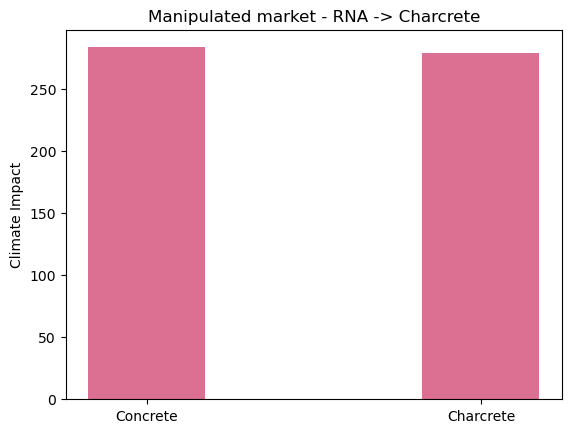

In [20]:
labels = ['Concrete', 'Charcrete']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, first_results, width, color='palevioletred')

ax.set_ylabel('Climate Impact')
ax.set_title('Manipulated market - RNA -> Charcrete')

plt.show()

In [21]:
fig.savefig("result1_v2")

In [22]:
RoW_results = replace_stuff(concrete_market, concrete_RoW, charcrete, ipcc)

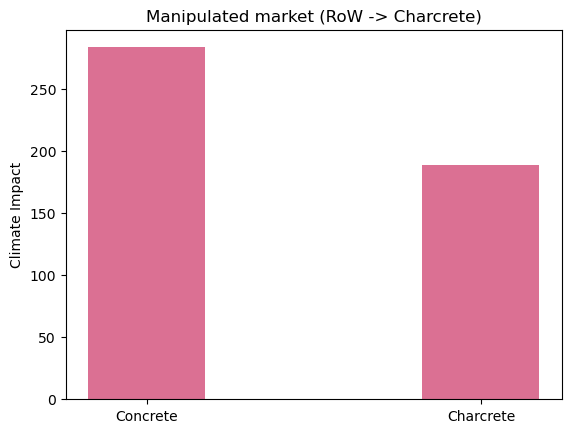

In [23]:
labels = ['Concrete', 'Charcrete']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, RoW_results, width, color='palevioletred')

ax.set_ylabel('Climate Impact')
ax.set_title('Manipulated market (RoW -> Charcrete)')

plt.show()

In [24]:
fig.savefig("result2_RoW_v2")

# Changing recursive_calculation

In [31]:
def return_recursive_calculation(
    activity,
    lcia_method,
    amount=1,
    max_level=3,
    cutoff=1e-2,
    file_obj=None,
    tab_character="  ",
    use_matrix_values=False,
    _lca_obj=None,
    _total_score=None,
    __level=0,
    __first=True,
    test_object = {}
):
    """
    "opened up" version of print_recursive_calculation, to save the values that are printed
    First level only (for now)
    Ideas for future improvement:
    Pass an argument for how many levels to return

    """
    activity = bd.get_activity(activity)
    #if file_obj is None:
        #file_obj = sys.stdout # i dont think we need this

    if _lca_obj is None:
        _lca_obj = bc.LCA({activity: amount}, lcia_method)
        _lca_obj.lci()
        _lca_obj.lcia()
        _total_score = _lca_obj.score
    elif _total_score is None:
        raise ValueError
    else:
        _lca_obj.redo_lcia({activity.id: amount})
        if abs(_lca_obj.score) <= abs(_total_score * cutoff):
            return
    if __first:
        print("Fraction of score | Absolute score | Amount | Activity\n")
    message = "{}{:04.3g} | {:5.4n} | {:5.4n} | {:.70}".format(
        tab_character * __level,
        _lca_obj.score / _total_score,
        _lca_obj.score,
        float(amount),
        str(activity),
    )
    print(message + "\n")
    '''
    print("TEST: ",      tab_character * __level, # this is just the indentation, we don't need it
          "Fraction of score? ", 
        _lca_obj.score / _total_score,
          "Absolute score? ",
        _lca_obj.score,
          "Amount? ", 
        float(amount),
          "Activity? ",
        str(activity))
    
    print("LEVEL: ", __level)
    '''
    if __level == 1:
        test_object[str(activity)] = {"Fraction of score": _lca_obj.score / _total_score,
          "Absolute score" : _lca_obj.score,
          "Amount" : float(amount),
          "Location" : activity['location']  
                                     }
    
    if __level < max_level:
        prod_exchanges = list(activity.production())
        if not prod_exchanges:
            prod_amount = 1
        elif len(prod_exchanges) > 1:
            warn("Hit multiple production exchanges; aborting in this branch")
            return
        else:
            prod_amount = _lca_obj.technosphere_matrix[
                _lca_obj.dicts.product[prod_exchanges[0].input.id],
                _lca_obj.dicts.activity[prod_exchanges[0].output.id],
            ]

        for exc in activity.technosphere():
            if exc.input.id == exc.output.id:
                continue

            if use_matrix_values:
                sign = (
                    -1
                    if exc.get("type") in ("technosphere", "generic technosphere")
                    else 1
                )
                tm_amount = (
                    _lca_obj.technosphere_matrix[
                        _lca_obj.dicts.product[exc.input.id],
                        _lca_obj.dicts.activity[exc.output.id],
                    ]
                    * sign
                )
            else:
                tm_amount = exc["amount"]

                
            return_recursive_calculation(
                activity=exc.input,
                lcia_method=lcia_method,
                amount=amount * tm_amount / prod_amount,
                max_level=max_level,
                cutoff=cutoff,
                file_obj=file_obj,
                tab_character=tab_character,
                __first=False,
                _lca_obj=_lca_obj,
                _total_score=_total_score,
                __level=__level + 1,
            )
            
    return(test_object)

In [26]:
concrete_market['location']

'GLO'

In [32]:
whats_this = return_recursive_calculation(concrete_market, ipcc, cutoff=0.001)

Fraction of score | Absolute score | Amount | Activity

0001 | 283.4 |     1 | 'market group for concrete, normal' (cubic meter, GLO, None)

  0.0144 | 4.086 | 0.0226 | 'market for concrete, normal' (cubic meter, BR, None)

    0.0144 | 4.086 | 0.0226 | 'concrete, all types to generic market for concrete, normal strength' 

      0.00275 | 0.7798 | 0.003616 | 'market for concrete, 30MPa' (cubic meter, BR, None)

      0.0115 | 3.253 | 0.01876 | 'market for concrete, 25MPa' (cubic meter, BR, None)

  0.00208 | 0.5893 | 0.002355 | 'market for concrete, normal' (cubic meter, CO, None)

    0.00208 | 0.5893 | 0.002355 | 'concrete, all types to generic market for concrete, normal strength' 

      0.00208 | 0.5893 | 0.002355 | 'market for concrete, 20MPa' (cubic meter, CO, None)

  0.0261 |  7.39 | 0.01907 | 'market for concrete, normal' (cubic meter, IN, None)

    0.0261 |  7.39 | 0.01907 | 'concrete, all types to generic market for concrete, normal strength' 

      0.0261 |  7.39 | 0.01

In [ ]:
whats_this

Now - it would be supercool if we could plot something from this dict

In [33]:
locations = []
amounts = []
score_fractions = []
absolute_scores = []

score_1 = []
score_2 = []
score_3 = []
score_4 = []
score_5 = []
score_6 = []
all_scores = []

for key, value in whats_this.items():
    #print(key)
    #print(value['Location'])
    #print(value['Fraction of score'])
    
    locations.append(value['Location'])
    amounts.append(value['Amount'])
    score_fractions.append(value['Fraction of score'])
    absolute_scores.append(value['Absolute score'])
    
    score = []
    #score.append(value['Location']) 
    score.append(value['Amount'])
    score.append(value['Fraction of score'])
    #score.append(value['Absolute score']) 
    all_scores.append(score)

'''
for (key, value, score) in zip(whats_this.items(), all_scores):
    #print(key)
    #print(value['Location'])
    #print(value['Fraction of score'])
    
    locations.append(value['Location'])
    amounts.append(value['Amount'])
    score_fractions.append(value['Fraction of score'])
    absolute_scores.append(value['Absolute score'])
    
    score.append(value['Location'], value['Amount'], value['Fraction of score'], value['Absolute score']) 
    
'''
    

"\nfor (key, value, score) in zip(whats_this.items(), all_scores):\n    #print(key)\n    #print(value['Location'])\n    #print(value['Fraction of score'])\n    \n    locations.append(value['Location'])\n    amounts.append(value['Amount'])\n    score_fractions.append(value['Fraction of score'])\n    absolute_scores.append(value['Absolute score'])\n    \n    score.append(value['Location'], value['Amount'], value['Fraction of score'], value['Absolute score']) \n    \n"

In [133]:
all_scores

[[0.0226016949011232, 0.014416282651548335],
 [0.00235506608812062, 0.0020789840026996546],
 [0.01906591647549, 0.02607040572019465],
 [0.0107245780174631, 0.012930554303038206],
 [0.0454155754069573, 0.04573046702868509],
 [0.00153183994392364, 0.001583355162659201],
 [0.897624403578512, 0.8968405662116437]]

In [134]:
all_scores[0][0]

0.0226016949011232

In [135]:
locations

['BR', 'CO', 'IN', 'PE', 'RNA', 'ZA', 'RoW']

In [136]:
amounts

[0.0226016949011232,
 0.00235506608812062,
 0.01906591647549,
 0.0107245780174631,
 0.0454155754069573,
 0.00153183994392364,
 0.897624403578512]

In [74]:
score_fractions

[0.014416282651548335,
 0.0020789840026996546,
 0.02607040572019465,
 0.012930554303038206,
 0.04573046702868509,
 0.001583355162659201,
 0.8968405662116437]

In [67]:
absolute_scores

[4.086234317413193,
 0.5892792186806887,
 7.389546188684299,
 3.6651109036471845,
 12.962107378206536,
 0.44879532114449,
 254.2056636568999]

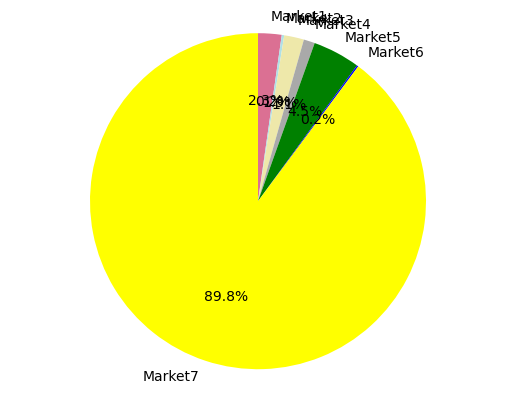

In [108]:
labels = 'Market1', 'Market2', 'Market3', 'Market4', 'Market5', 'Market6', 'Market7'
#sizes = [15, 30, 45, 10]
nice_colors = ['palevioletred', 'powderblue', 'palegoldenrod', 'darkgray', 'green', 'blue', 'yellow']

fig1, ax1 = plt.subplots()
ax1.pie(amounts, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False, colors = nice_colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

  Amount        BR        CO        IN        PE       RNA        ZA       RoW
0         0.022602  0.002355  0.019066  0.010725  0.045416  0.001532  0.897624


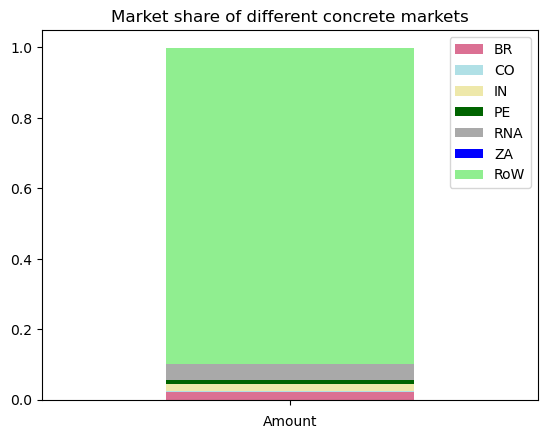

In [53]:
nice_colors = ['palevioletred', 'powderblue', 'palegoldenrod', 'darkgreen', 'darkgray', 'blue', 'lightgreen']

 # create data
df = pd.DataFrame([[''] + amounts],
                  columns=['Amount'] + locations)
# view data
print(df)
 
# plot data in stack manner of bar type
df.plot(x='Amount', kind='bar', stacked=True,
        title='Market share of different concrete markets', color=nice_colors)
plt.show()

# Changing market shares

In [54]:
def change_market_shares(main_act, repl_act, market_share, method):
    
    gangnam_style = 1_000_000

    indices = np.array(
    [
        (gangnam_style, gangnam_style), # Production exchange for new main_act ( activity produces itself ) - need to have this to make matrix square
        (main_act.id, gangnam_style)]
        +
        [
        
        (exc.input.id, gangnam_style) for exc in main_act.exchanges()
        #(sub_act.id, gangnam_style), # subtract sub_act - here we need to add all the sub_acts
    ] + [
        (node.id, gangnam_style) for node in [repl_act] # replace with this - something about new dps replacing old ones - could also have the values being added together?
        # see gh bw processing -> policies
    ], dtype=bwp.INDICES_DTYPE
    )
    
    data = np.array([
            1,
            1,
        ]
        +
        [
        exc['amount']*(market_share) for exc in list(main_act.exchanges()) # amount*0.1 - what we want to " remove"
        ]
        +
        [
            market_share # new activity - same amount
            # 0 # (i was just testing something)
        ]
    ) 
    flip = np.array(
        [False, True] + [False for exc in list(main_act.exchanges())] + [True for _ in [repl_act]] # neg for sub acts, pos for new act
    )
    
    dp = bwp.create_datapackage()

    dp.add_persistent_vector(
        matrix="technosphere_matrix",
        data_array=data,
        indices_array=indices,
        flip_array=flip,
        name="New technosphere",
    )
    
    _, data_objs, _ = bd.prepare_lca_inputs({main_act: 1}, ipcc) # data_objs - still using ei
    
    
    lca = bc.LCA({main_act.id: 1}, data_objs=data_objs + [dp]) # old motor + add [dp] (new motor)
    lca.lci()
    lca.lcia()
    lcascore1 = lca.score
    
    lca.lcia({gangnam_style: 1}) # new motor
    lcascore2 = lca.score

    
    return(lcascore1, lcascore2)

In [55]:
print(change_market_shares(concrete_market, wood_chipping_act, 0.1, ipcc))

(283.4457686617526, 254.53357198151193)


In [59]:
lca1, lca2 = change_market_shares(concrete_market, wood_chipping_act, 0.1, ipcc)

uhm... so now we get results... how do we check if this is reasonable?

ok - let's break down what we have done

We have taken away 10% of the OG act, and replaces that with 0.1 of the replacement act

So 283 x 0.9 + 0.1 of repl_act should be our result

let's do an LCA of the repl_act


In [57]:
_, data_objs, _ = bd.prepare_lca_inputs({wood_chipping_act: 1}, ipcc) # data_objs - still using ei    
lca = bc.LCA({wood_chipping_act.id: 1}, data_objs=data_objs) # old motor + add [dp] (new motor)
lca.lci()
lca.lcia()
wc_score = lca.score

In [58]:
wc_score

277.7695616489718

In [60]:
lca1

283.4457686617526

In [62]:
# What we should get:
lca1*0.9 + wc_score*0.1

282.8781479604745

In [63]:
# what we get
lca2

254.53357198151193

???

# Helpers (no need to run these)

This section basically just contains me playing around in the bw framework

## Template for searching activities etc

In [22]:
'ei 3.8 cutoff', 'a63718ddc8a975480cf624318b8e5eb0'

('ei 3.8 cutoff', 'a63718ddc8a975480cf624318b8e5eb0')

In [63]:
bd.projects.current

'ei38-teaching-25'

In [64]:
bi.databases

Databases dictionary with 2 object(s):
	biosphere3
	ei 3.8 cutoff

In [65]:
concrete_market = bd.get_activity(('ei 3.8 cutoff', 'a63718ddc8a975480cf624318b8e5eb0'))

In [77]:
concrete_market

'market group for concrete, normal' (cubic meter, GLO, None)

In [78]:
list(concrete_market.exchanges())

[Exchange: 1.0 cubic meter 'market group for concrete, normal' (cubic meter, GLO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>,
 Exchange: 0.0226016949011232 cubic meter 'market for concrete, normal' (cubic meter, BR, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>,
 Exchange: 0.000680925588410356 cubic meter 'market for concrete, normal' (cubic meter, CH, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>,
 Exchange: 0.00235506608812062 cubic meter 'market for concrete, normal' (cubic meter, CO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>,
 Exchange: 0.01906591647549 cubic meter 'market for concrete, normal' (cubic meter, IN, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>,
 Exchange: 0.0107245780174631 cubic meter 'market for concrete, normal' (cubic meter, PE, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>,
 Exchange: 0.0454155754069573 cubic

In [43]:
for exc in concrete_market.technosphere():
    print(exc)

Exchange: 0.0226016949011232 cubic meter 'market for concrete, normal' (cubic meter, BR, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
Exchange: 0.000680925588410356 cubic meter 'market for concrete, normal' (cubic meter, CH, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
Exchange: 0.00235506608812062 cubic meter 'market for concrete, normal' (cubic meter, CO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
Exchange: 0.01906591647549 cubic meter 'market for concrete, normal' (cubic meter, IN, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
Exchange: 0.0107245780174631 cubic meter 'market for concrete, normal' (cubic meter, PE, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
Exchange: 0.0454155754069573 cubic meter 'market for concrete, normal' (cubic meter, RNA, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
Exchange: 0.00153183994392364 cubic me

In [40]:
for exch in concrete_market.exchanges():
    print(exch)
    try:
        print(exch.input.id)
    except:
        exch().delete()

Exchange: 1.0 cubic meter 'market group for concrete, normal' (cubic meter, GLO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
18901
Exchange: 0.0226016949011232 cubic meter 'market for concrete, normal' (cubic meter, BR, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
5266
Exchange: 0.000680925588410356 cubic meter 'market for concrete, normal' (cubic meter, CH, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
18417
Exchange: 0.00235506608812062 cubic meter 'market for concrete, normal' (cubic meter, CO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
11087
Exchange: 0.01906591647549 cubic meter 'market for concrete, normal' (cubic meter, IN, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
14553
Exchange: 0.0107245780174631 cubic meter 'market for concrete, normal' (cubic meter, PE, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
23135
Exchange: 0.

TypeError: 'Exchange' object is not callable

In [36]:
for exch in list(concrete_market.exchanges()):
    print(exch)
    try:
        print(exch.input.id)
    except:
        exch().delete()

Exchange: 1.0 cubic meter 'market group for concrete, normal' (cubic meter, GLO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
18901
Exchange: 0.0226016949011232 cubic meter 'market for concrete, normal' (cubic meter, BR, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
5266
Exchange: 0.000680925588410356 cubic meter 'market for concrete, normal' (cubic meter, CH, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
18417
Exchange: 0.00235506608812062 cubic meter 'market for concrete, normal' (cubic meter, CO, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
11087
Exchange: 0.01906591647549 cubic meter 'market for concrete, normal' (cubic meter, IN, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
14553
Exchange: 0.0107245780174631 cubic meter 'market for concrete, normal' (cubic meter, PE, None) to 'market group for concrete, normal' (cubic meter, GLO, None)>
23135
Exchange: 0.

TypeError: 'Exchange' object is not callable

In [ ]:
bd.Database(ecoinvent).search('copper')

In [ ]:
activity_I_want = [act for act in bd.Database(biosphere) if 'Carbon dioxide' in act['name'] 
                                            and 'fossil' in act['name']
                                            and 'non' not in act['name']
                                            and 'urban air close to ground' in str(act['categories'])
         ][0]
activity_I_want

'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))

In [32]:
activity_I_want.key

('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9')

In [34]:
bd.get_activity(activity_I_want.key)

'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))

In [51]:
bd.Database(biosphere).search('carbon dioxide', filter={'categories':'urban', 'name':'fossil'})

Excluding 19 filtered results


['Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'urban air close to ground'))]

In [ ]:
# Using search
bd.Database(ecoinvent).search('transport', filter={'name':'lorry'})

## Methods

In [39]:
ipcc2013 = [m for m in bd.methods if 'IPCC' in m[0]
                    and ('2013') in str(m)
                    and 'GWP 100' in str(m)
                    and 'no LT' not in str(m)][0]

In [42]:
type(ipcc2013)

tuple

In [40]:
ipcc_2013_method = bd.Method(ipcc2013)

In [41]:
type(ipcc_2013_method)

bw2data.method.Method

In [41]:
ipcc_2013_method.name

('IPCC 2013', 'climate change', 'GWP 100a')

In [42]:
ipcc_2013_method.metadata

{'description': "IPCC characterisation factors for the direct global warming potential of air emissions in ecoinvent 3.2. See the ecoinvent report 'Implementation of IPCC impact assessment method 2007 and 2013 to ecoinvent database 3.2 (2015.11.30)' for more details. Doesn't include: indirect formation of dinitrogen monoxide from nitrogen emissions, radiative forcing due to emissions of NOx, water, sulphate, etc. in the lower stratosphere + upper troposphere, carbon climate feedbacks, and any emissions which have cooling effects (e.g. black carbon). All CO is assumed to convert completely to CO2. Biogenic CO2 uptake and biogenic CO2 emissions are not characterised, except for 'Carbon dioxide, from soil or biomass stock' (deforestation and land transformation).",
 'filename': 'LCIA_Implementation_3.8.xlsx',
 'unit': 'kg CO2-Eq',
 'abbreviation': 'ipcc-2013cg.bd5af3f67229a1cc291b8ecb7f316fcf',
 'num_cfs': 211}

In [43]:
ipcc_2013_method.metadata['unit']

'kg CO2-Eq'

## Creating LCI

In [74]:
# creating new activity? let's do that in our database?
bd.databases

Databases dictionary with 5 object(s):
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	biosphere3
	charcrete
	ei 3.8 cutoff

In [73]:
user_db = bd.Database("charcrete")

In [70]:
bd.databases

Databases dictionary with 4 object(s):
	EXIOBASE 3.8.1 2017 monetary
	EXIOBASE 3.8.1 2017 monetary biosphere
	biosphere3
	ei 3.8 cutoff

In [84]:
example_data3 = {
    ("charcrete", "A"): {
        "name": "A",
        "exchanges": [{
            "amount": 1.0,
            "input": ("charcrete", "B"),
            "type": "technosphere"
            }],
        'unit': 'kilogram',
        'location': 'here',
        'categories': ("very", "interesting")
        },
    ("charcrete", "B"): {
        "name": "B",
        "exchanges": [],
        'unit': 'microgram',
        'location': 'there',
        'categories': ('quite', 'boring')
        }
    }

In [85]:
user_db.write(example_data3)

Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 10/26/2022 12:16:34
  Finished: 10/26/2022 12:16:34
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 0.20


In [87]:
len(user_db)

2

In [109]:
user_db.search('*')

[]

In [104]:
act = user_db.search('*')[0]

In [107]:
del(act)

In [108]:
user_db.search('*')

[]

In [110]:
user_db

Brightway2 SQLiteBackend: charcrete

In [111]:
len(user_db)

0

## find data

In [112]:
bd.Database(ecoinvent).search('forwarding')

['market for forwarding, forwarder' (hour, GLO, None),
 'forwarding, forwarder' (hour, RER, None),
 'forwarding, forwarder' (hour, RoW, None)]

In [115]:
activity_I_want = [act for act in bd.Database(ecoinvent) if 'forwarding' in act['name'] and act['location'] == 
                   'RER'
         ][0]
activity_I_want

'forwarding, forwarder' (hour, RER, None)

In [116]:
forwarding_act = [act for act in bd.Database(ecoinvent) if 'forwarding' in act['name'] and act['location'] == 
                   'RER'][0]

In [117]:
forwarding_act

'forwarding, forwarder' (hour, RER, None)

In [118]:
bd.Database(ecoinvent).search('wood chipping, mobile chipper, at forest road')

['market for wood chipping, chipper, mobile, diesel, at forest road' (hour, GLO, None),
 'wood chipping, mobile chipper, at forest road' (hour, RER, None),
 'wood chipping, mobile chipper, at forest road' (hour, RoW, None)]

In [119]:
activity_I_want = [act for act in bd.Database(ecoinvent) if 'wood chipping, mobile chipper, at forest road' in act['name'] and act['location'] == 
                   'RER'
         ][0]
activity_I_want

'wood chipping, mobile chipper, at forest road' (hour, RER, None)

In [120]:
activity_I_want

'wood chipping, mobile chipper, at forest road' (hour, RER, None)

In [121]:
wood_chipping_act = [act for act in bd.Database(ecoinvent) if 'wood chipping, mobile chipper, at forest road' in act['name'] 
                     and act['location'] == 'RER'][0]

In [122]:
wood_chipping_act

'wood chipping, mobile chipper, at forest road' (hour, RER, None)